In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms


In [2]:
# Define transformations for the MNIST dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)

# Create data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


In [3]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) model.

    This model consists of an encoder and a decoder with convolutional layers.
    The encoder maps the input data to a latent space defined by mean (mu) and
    log variance (logvar). The decoder reconstructs the data from samples drawn
    from this latent space. The reparameterization trick is used the
    backpropagation algorithm. Please refer to "Understanding Deep Learning"
    by Simon J.D. Prince, MIT Press, 2024 for details.

    Methods:
        encode(x): Encodes input tensor to latent space representations (mu and logvar).
        reparameterize(mu, logvar): Samples from the latent space using the reparameterization trick.
        decode(z): Reconstructs input data from latent variable z.
        forward(x): Performs a full forward pass through the network.
    """

    def __init__(self):
        super(VAE, self).__init__()
        # Encoder layers
        self.enc_conv1 = nn.Conv2d(
            1, 32, kernel_size=4, stride=2, padding=1
        )  # Output: [batch, 32, 14, 14]
        self.enc_conv2 = nn.Conv2d(
            32, 64, kernel_size=4, stride=2, padding=1
        )  # Output: [batch, 64, 7, 7]
        self.enc_fc1 = nn.Linear(64 * 7 * 7, 128)
        self.enc_mu = nn.Linear(128, 2)
        self.enc_logvar = nn.Linear(128, 2)
        # Decoder layers
        self.dec_fc1 = nn.Linear(2, 128)
        self.dec_fc2 = nn.Linear(128, 64 * 7 * 7)
        self.dec_conv1 = nn.ConvTranspose2d(
            64, 32, kernel_size=4, stride=2, padding=1
        )  # Output: [batch, 32, 14, 14]
        self.dec_conv2 = nn.ConvTranspose2d(
            32, 1, kernel_size=4, stride=2, padding=1
        )  # Output: [batch, 1, 28, 28]
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        """
        Encodes input tensor to latent space representations.

        Args:
            x (torch.Tensor): Input tensor with shape [batch_size, channels, height, width].

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Mean (mu) and log variance (logvar) of the latent space.
        """
        h = self.relu(self.enc_conv1(x))
        h = self.relu(self.enc_conv2(h))
        h = h.view(-1, 64 * 7 * 7)
        h = self.relu(self.enc_fc1(h))
        mu = self.enc_mu(h)
        logvar = self.enc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Samples from the latent space using the reparameterization trick.

        Args:
            mu (torch.Tensor): Mean of the latent distribution.
            logvar (torch.Tensor): Log variance of the latent distribution.

        Returns:
            torch.Tensor: Sampled latent variable z.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        """
        Reconstructs input data from latent variable z.

        Args:
            z (torch.Tensor): Sampled latent variable.

        Returns:
            torch.Tensor: Reconstructed input data.
        """
        h = self.relu(self.dec_fc1(z))
        h = self.relu(self.dec_fc2(h))
        h = h.view(-1, 64, 7, 7)
        h = self.relu(self.dec_conv1(h))
        h = self.sigmoid(self.dec_conv2(h))
        return h

    def forward(self, x):
        """
        Performs a full forward pass through the VAE.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Reconstructed input, mean, and log variance.
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [4]:
# Select device
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)
print(f"Using device: {device}")


Using device: cuda


In [5]:
# Initialize the VAE model
model = VAE().to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# Define the loss function
# The loss function in a Variational Autoencoder (VAE) is a combination of
# two components: the reconstruction loss and the Kullback-Leibler (KL) divergence.
# The reconstruction loss measures how well the decoder can reconstruct the input
# data from the latent representation, here using binary cross-entropy.
# The KL divergence acts as a regularizer, encouraging the latent variables to
# approximate a standard normal distribution.
def loss_function(input, target, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(input, target, reduction="sum")
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [7]:
# Training loop
num_epochs = 15
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for _, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(input=recon_batch, target=data, mu=mu, logvar=logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(
        "Epoch: %d \t Average loss: %.4f"
        % (epoch + 1, train_loss / len(train_loader.dataset))
    )


Epoch: 1 	 Average loss: 173.4508
Epoch: 2 	 Average loss: 155.7817
Epoch: 3 	 Average loss: 152.5128
Epoch: 4 	 Average loss: 150.4837
Epoch: 5 	 Average loss: 149.0838
Epoch: 6 	 Average loss: 148.1356
Epoch: 7 	 Average loss: 147.1877
Epoch: 8 	 Average loss: 146.5373
Epoch: 9 	 Average loss: 145.8632
Epoch: 10 	 Average loss: 145.3878
Epoch: 11 	 Average loss: 144.8400
Epoch: 12 	 Average loss: 144.4210
Epoch: 13 	 Average loss: 144.0802
Epoch: 14 	 Average loss: 143.6755
Epoch: 15 	 Average loss: 143.4311


In [ ]:
# Save the model
torch.save(model.state_dict(), "vae_cnn_model.pth")

# Load the model
# loaded_model = VAE().to(device)
# loaded_model.load_state_dict(torch.load('vae_cnn_model.pth'))

# # Set the model to evaluation mode
# loaded_model.eval()

/tmp/ipykernel_16289/3529145291.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('vae_cnn_model.pth'))


VAE(
  (enc_conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_fc1): Linear(in_features=3136, out_features=128, bias=True)
  (enc_mu): Linear(in_features=128, out_features=2, bias=True)
  (enc_logvar): Linear(in_features=128, out_features=2, bias=True)
  (dec_fc1): Linear(in_features=2, out_features=128, bias=True)
  (dec_fc2): Linear(in_features=128, out_features=3136, bias=True)
  (dec_conv1): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [8]:
# Extract latent and labels variables from the model
model.eval()
latents = []
labels_list = []
with torch.no_grad():
    for data, labels in train_loader:
        data = data.to(device)
        mu, logvar = model.encode(data)
        z = model.reparameterize(mu, logvar)
        latents.append(z.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
latents = np.concatenate(latents, axis=0)
labels = np.concatenate(labels_list, axis=0)


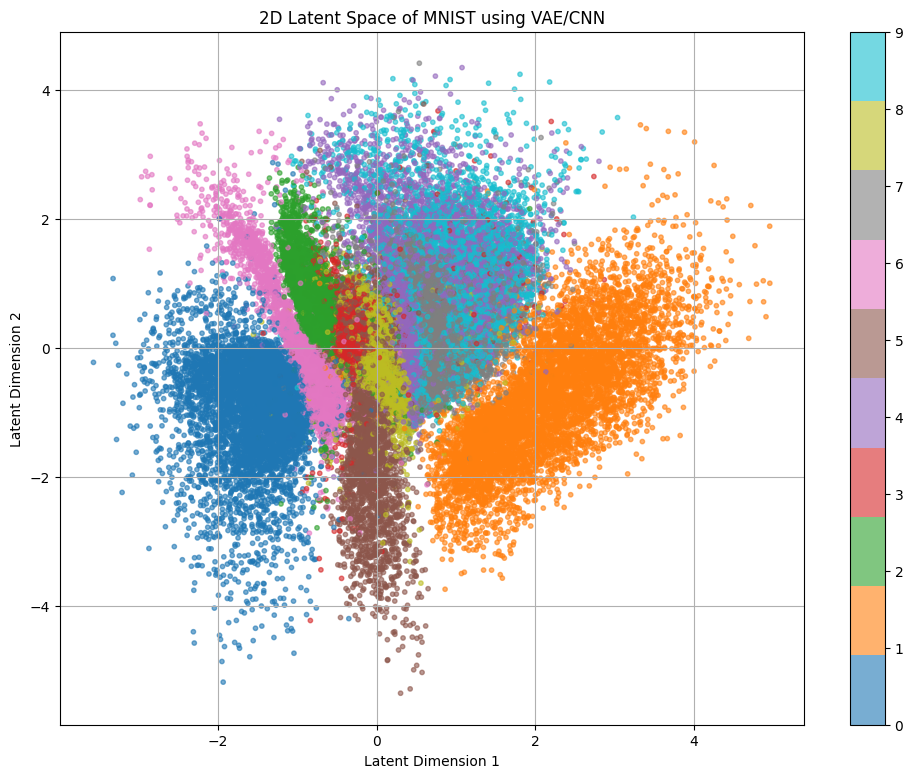

In [9]:
# Visualize the latent space
plt.figure(figsize=(12, 9))
scatter = plt.scatter(
    latents[:, 0], latents[:, 1], c=labels, cmap="tab10", alpha=0.6, s=10
)
plt.colorbar(scatter, ticks=range(10))
plt.title("2D Latent Space of MNIST using VAE/CNN")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.show()

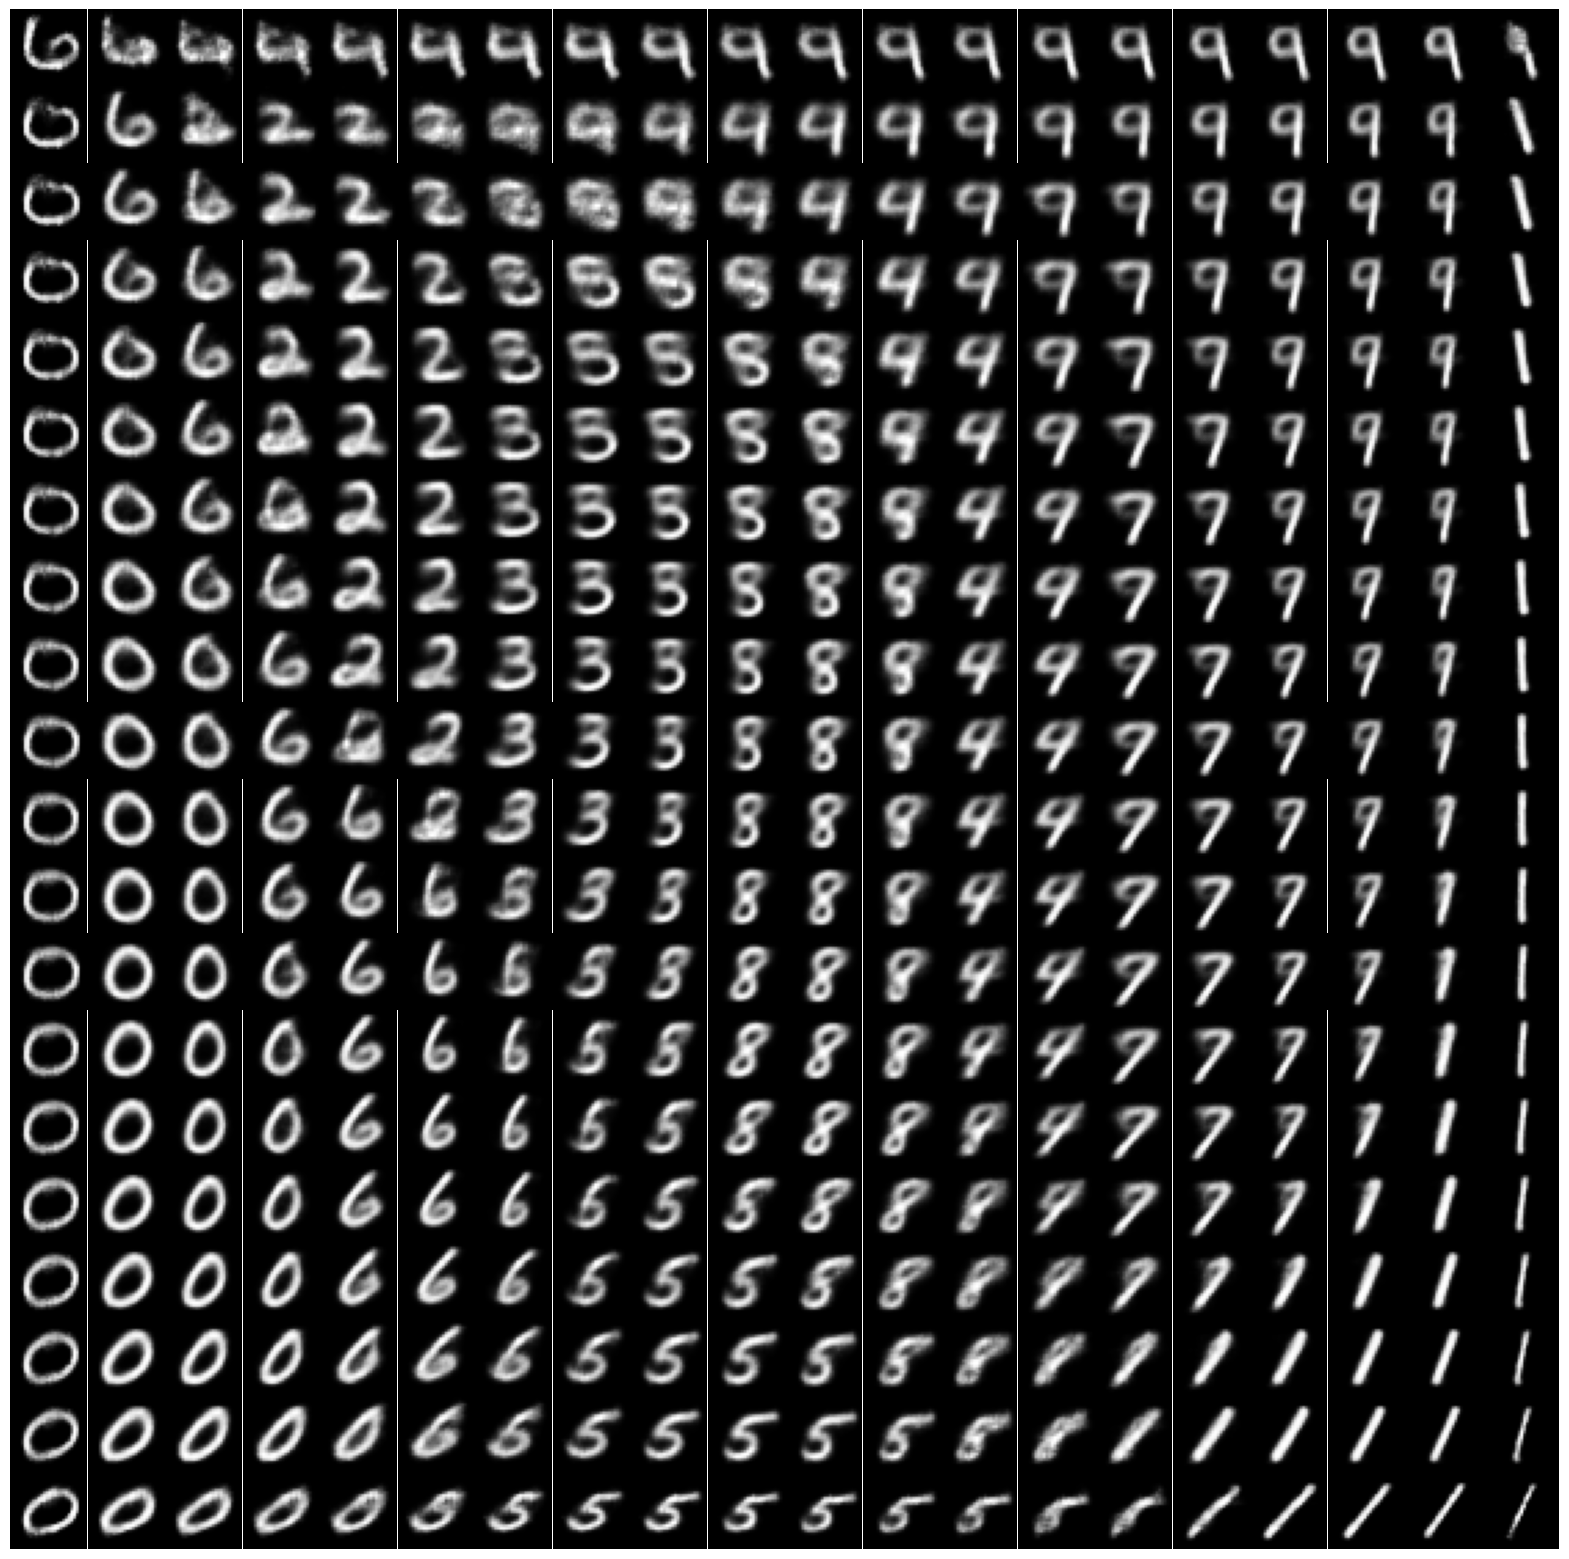

In [10]:
# Define the grid size
k = 20  # Number of points along each dimension

grid_x = torch.linspace(0.001, 0.999, k)
grid_y = torch.linspace(0.001, 0.999, k)
mesh_x, mesh_y = torch.meshgrid(
    grid_x, grid_y, indexing="xy"
)  # Ensure correct axis indexing

# Stack the grid coordinates into a shape (k*k, 2)
coords = torch.stack([mesh_x, mesh_y], dim=-1).view(-1, 2)

# Map the uniformly distributed samples to the standard normal distribution using the inverse CDF
normal = torch.distributions.normal.Normal(0, 1)
z = normal.icdf(coords)  # Shape: (k*k, 2)

# Ensure the model is in evaluation mode
model.eval()

# Move the grid points to the same device as the model
z = z.to(device)

with torch.no_grad():
    # Decode the latent variables to generate images
    reconstructed = model.decode(z).cpu()  # Shape: (k*k, 28*28)

# Reshape the reconstructed images for visualization
images = reconstructed.view(-1, 1, 28, 28)  # Shape: (k*k, 1, 28, 28)

# Convert images to NumPy array for plotting
images = images.numpy()

# Create a figure with a grid of subplots
fig, axes = plt.subplots(k, k, figsize=(k, k))

for i in range(k):
    for j in range(k):
        idx = i * k + j  # Index of the current image
        # Reverse the order of rows to have the lowest latent y-values at the bottom
        ax = axes[k - i - 1, j]
        ax.imshow(images[idx, 0, :, :], cmap="gray")
        ax.axis("off")

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()